# Sanity Check Experiments
Testing GP-based BO against random search and default hyperparameter settings for scikit-learn's Random Forest Classifier.

Experiment configurations:
- 500 evaluations
- 20 replicates
- 3 datasets:
  - Blood Transfusion Service Center: Classify whether someone donated blood in March 2007 (class 2 stands for donating blood; 1 stands for not donating blood).
  - Phoneme: Classify nasal (class 0) and oral sounds (class 1)
  - Spam Base: Classify whether email is spam (class 1) or not (class 0)
- 2-3 hyperparameters (numerical values only)
- sigma (RBF kernel parameter) = 5, 10, 20, 50

This file is primarily for debugging and visualization. I've also updated the Bayesian Optimization code to be more general and capable of handling any number of hyperparameters

In [80]:
import numpy as np
import pandas as pd
import openml
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

In [95]:
def vector_to_param_dict(values, hyperparam_names, config):
    """
    Converts a list of hyperparameter values into a dictionary using the provided configuration.
    
    Parameters:
    - values: List of values, one for each hyperparameter.
    - hyperparam_names: List of hyperparameter names.
    - config: Dictionary mapping each hyperparameter to its bounds and type.

    Returns:
    - A dictionary mapping hyperparameter names to properly typed values.
    """
    assert len(hyperparam_names) == len(values)
    param_dict = {}
    for name, value in zip(hyperparam_names, values):
        param_type = config[name]['type']
        if param_type == 'int':
            param_dict[name] = int(round(value))
        elif param_type == 'float':
            param_dict[name] = float(value)
        else:
            raise ValueError("Unsupported type: ", param_type)
    return param_dict

# Test 
# these have to be in the same order!!
hyperparam_names = ['n_estimators', 'max_depth'] # 'min_samples_split'
hyperparam_config = {'n_estimators': {'bounds': (50, 500), 'type': 'int'},
                     'max_depth': {'bounds': (10, 100), 'type': 'int'}}
                     # 'min_samples_split': {'bounds': (0.01, 0.5), 'type': 'float'}}

print(vector_to_param_dict([3, 2], hyperparam_names, hyperparam_config))


evaluations = 500
replicates = 20

{'n_estimators': 3, 'max_depth': 2}


In [116]:
# 3 datasets: blood-transfusion-service-center (1464), phoneme (1489), spambase (44)
openml_tasks = [1464, 1489, 44]
dataset = openml.datasets.get_dataset(openml_tasks[0])
df, *_ = dataset.get_data()
df

,V1,V2,V3,V4,Class
0,2,50,12500.0,98,2
1,0,13,3250.0,28,2
2,1,16,4000.0,35,2
3,2,20,5000.0,45,2
4,1,24,6000.0,77,1
...,...,...,...,...,...
743,23,2,500.0,38,1
744,21,2,500.0,52,1
745,23,3,750.0,62,1
746,39,1,250.0,39,1


In [118]:
X = df.drop(columns='Class').values 
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
print(X_train, X_train.shape)
print(X_test, X_test.shape)
print(y_train, y_train.shape)
print(y_test, y_test.shape)

[[8.00e+00 1.50e+01 3.75e+03 7.70e+01]
 [4.00e+00 7.00e+00 1.75e+03 5.20e+01]
 [2.00e+00 6.00e+00 1.50e+03 3.50e+01]
 ...
 [4.00e+00 2.00e+00 5.00e+02 4.00e+00]
 [4.00e+00 6.00e+00 1.50e+03 2.30e+01]
 [1.60e+01 1.00e+00 2.50e+02 1.60e+01]] (598, 4)
[[2.30e+01 3.00e+00 7.50e+02 3.50e+01]
 [1.20e+01 1.20e+01 3.00e+03 5.80e+01]
 [1.40e+01 5.00e+00 1.25e+03 5.00e+01]
 [1.40e+01 2.00e+00 5.00e+02 1.40e+01]
 [2.00e+00 3.00e+00 7.50e+02 2.40e+01]
 [4.00e+00 3.30e+01 8.25e+03 9.80e+01]
 [3.00e+00 5.00e+00 1.25e+03 1.20e+01]
 [1.60e+01 5.00e+00 1.25e+03 4.00e+01]
 [1.10e+01 1.00e+00 2.50e+02 1.10e+01]
 [3.00e+00 8.00e+00 2.00e+03 5.00e+01]
 [1.40e+01 3.00e+00 7.50e+02 3.50e+01]
 [2.30e+01 8.00e+00 2.00e+03 4.60e+01]
 [9.00e+00 2.00e+00 5.00e+02 2.60e+01]
 [2.30e+01 1.00e+00 2.50e+02 2.30e+01]
 [2.10e+01 2.00e+00 5.00e+02 2.30e+01]
 [2.10e+01 1.00e+00 2.50e+02 2.10e+01]
 [4.00e+00 1.00e+00 2.50e+02 4.00e+00]
 [1.60e+01 8.00e+00 2.00e+03 7.60e+01]
 [1.40e+01 1.80e+01 4.50e+03 7.80e+01]
 [3.90e+01

Accuracy (default):  0.76


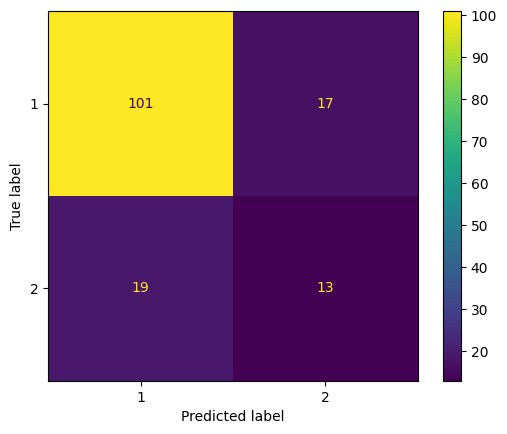

In [119]:
# Default Random Forest Classifier settings (make sure to do this 20 times (different seeds) in the actual run file)
classifier = RandomForestClassifier(random_state=11)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (default): ", accuracy)
        
# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = c_matrix.ravel()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [120]:
# We're trying to MAXIMIZE this objective function
def objective(X):
    """
    Evaluates a set of hyperparameter configurations using cross-validated accuracy.

    Parameters:
    - X: array-like of shape (n_samples, n_features)
      Each row represents a set of hyperparameter values, e.g., x_n = [n_estimators, max_depth, ...]

    Returns:
    - An array of shape (n_samples, 1) containing the cross-validated accuracy scores 
      for each hyperparameter configuration.

    Notes:
    - This function assumes that 'hyperparam_names', 'hyperparam_config', 'X_train', and 'y_train' are
      defined in the global scope.
    """
    scores = []
    for param in X: # iterate through each input
        # convert each row of X into a dictionary with appropriate types 
        param_dict = vector_to_param_dict(param, hyperparam_names, hyperparam_config)
        print(param_dict)
        model = RandomForestClassifier(**param_dict)
        # No need to invert, already maximizing - higher accuracy value is better 
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean() 
        scores.append(score)
    return np.array(scores).reshape(-1,1)
    

def squared_euclidean_distance(xa, xb):
    """
    Computes the pairwise squared Euclidean distances between two sets of vectors.
    The squared Euclidean distance between two vectors a and b is defined as:
      ||a - b||^2 = ||a||^2 + ||b||^2 - 2ab

    Parameters:
    - xa : array of shape (n_samples_a, n_features)
      First set of input vectors.
    - xb : array of shape (n_samples_b, n_features)
      Second set of input vectors.
    
    Returns:
    - An array of shape (n_samples_a, n_samples_b), representing the matrix of 
      squared Euclidean distances between each pair of vectors from 'xa' and 'xb'.
    """
    # Reduce (n,d) to (n,1), (m,d) to (1,m)
    xa2 = np.sum(xa**2, axis=1).reshape(-1, 1)   # shape: (n,1)
    xb2 = np.sum(xb**2, axis=1).reshape(1, -1)   # shape: (1,m)

    # print("xa2:", xa2)
    # print("xb2:", xb2)

    # Compute pairwise dot products
    dot_prod = np.dot(xa, xb.T)                  # shape: (n,m)

    # Apply the distance formula
    return xa2 + xb2 - 2 * dot_prod              # shape: (n,m)


def rbf_kernel(xa, xb, sigma=1):
    """
    Computes the Radial Basis Function (RBF) Kernel between two sets of input vectors.
    
    Parameters:
    - xa : array of shape (n_samples_a, n_features)
      First set of input vectors.
    - xb : array of shape (n_samples_b, n_features)
      Second set of input vectors.
    - sigma: float, the length scale parameter of the RBF kernel. Smaller values lead to narrower kernels.
      
    Returns:
    - An array of shape (n_samples_a, n_samples_b), representing the kernel matrix, where 
      each entry (i, j) represents the similarity between xa[i] and xb[j] based on the squared Euclidean distance.
    """
    xa = np.array(xa)
    xb = np.array(xb)
    sqdist = squared_euclidean_distance(xa, xb)
    return np.exp(-0.5 * 1/(sigma**2) * sqdist)


def GP(X1, y1, X2, sigma=1.0, noise=0):
    """
    Compute the posterior mean and covariance of a Gaussian Process (GP) using the RBF Kernel. 

    Parameters:
    - X1: array of shape (n_samples_train, n_features), representing the training input data.
    - y1: array of shape (n_samples_train, 1), representing the training target values. 
    - X2: array of shape (n_samples_test, n_features), representing the test input data where
      predictions are to be made.
    - sigma: float, length scale parameter for the RBF kernel. Controls the smoothness of the function.
    - noise: float, standard deviation of Gaussian noise added to the training targets. 
      Helps model noisy observations.
      
    Returns:
    - mu: array of shape (n_samples_test, 1), representing the posterior mean predictions for the test inputs.
    - cov: array of shape (n_samples_test, n_samples_test), the posterior covariance matrix 
      for representing uncertainty in the predictions.

    Notes:
    - The function assumes a zero-mean GP prior.
    """
    # In case 1D array passed
    y1 = y1.reshape(-1, 1)
    
    # Kernel (covariance) matrices
    # Add noise on diagonal for K11
    K11 = rbf_kernel(X1, X1, sigma) + (noise**2) * np.eye(len(X1)) + 1e-8 * np.eye(len(X1)) # shape: (n,n)
    K22 = rbf_kernel(X2, X2, sigma)                                # shape: (m,m)
    K12 = rbf_kernel(X1, X2, sigma)                                # shape: (n,m)

    # Invert K11
    K11_inv = np.linalg.inv(K11)

    # Posterior mean
    mu = K12.T @ K11_inv @ y1 # # @ is matrix multiplication

    # Posterior covariance
    cov = K22 - K12.T @ K11_inv @ K12

    # Regularize to ensure diagonal values are non-negative
    cov += 1e-6 * np.eye(cov.shape[0])

    return mu, cov


# Acquisition function: UCB
def acquisition_ucb(mu, std, beta=2.0):
    """
    Computes the Upper Confidence Bound (UCB) acquisition function for Bayesian Optimization (BO).

    Parameters:
    - mu: array of shape (n_samples, 1), representing the predicted mean values 
      from the GP for each candidate input.
    - std: array of shape (n_samples, 1), representing the predicted standard deviations (uncertainty)
      from the GP for each candidate input.
    - beta: float, exploration-exploitation trade-off parameter. Higher values encourage exploration by
      giving more weight to uncertainty. 
    """
    return mu + beta * std

def bayesian_opt(objective, init_points=5, iterations=10, beta=2.0, sigma=1.0, noise=0):
    """
    Performs Bayesian Optimization (BO) using a GP surrogate model and 
    the UCB acquisition function.

    Parameters:
    - objective: callable, the objective function to be maximized. It should accept a 2D array of 
      hyperparameter configurations and return a 2D array of scores
    - init_points: int, number of initial random samples to evaluate as training data, before starting the 
      optimization loop.
    - iteration: int, number of optimization steps to perform after initial sampling.
    - beta: float, exploration-exploitation trade-off parameter for the UCB acquisition function.
      Higher values encourage exploration.
    - sigma: float, length scale parameter for the RBF kernel used in the GP.
    - noise: float, standard deviation of Gaussian noise added to observations (from the latent objective). 

    Notes:
    - For plotting and scoring (acquisition), the function uses a grid consisting of 100 points 
      along each dimension.
    - This function assumes that 'hyperparam_names' and 'hyperparam_config' are
      defined in the global scope.
    """
    
    # === Step 1: Generate initial training data ===
    # Randomly sample 'init_points' configurations from the hyperparameter space
    X_param_train = []
    for i in range(init_points):
        sample = [np.random.uniform(*param['bounds']) for param in hyperparam_config.values()]
        X_param_train.append(sample)
    print("X train: ", X_param_train)
    
    # Evaluate the objective function on the initial samples
    y_param_train = objective(X_param_train)
    print("y train: ", y_param_train)


    # === Step 2: Create a grid for acquisition function evaluation ===
    # Generate 100 evenly spaced values for each hyperparameter dimension
    dimensions = []
    for param in hyperparam_config.values():
        dimensions.append(np.linspace(*param['bounds'], 100))
    
    # Create a meshgrid of all combinations of hyperparameter values
    grids = np.meshgrid(*dimensions) 
    
    # Flatten the grid into a 2D array of shape (100*num_dimensions, num_dimensions)
    X_grid = np.vstack([grid.ravel() for grid in grids]).T
    print("X_grid: ", X_grid)

    # === Step 3: Bayesian Optimization Loop ===
    mu = None # Posterior mean predictions from GP
    cov = None # Posterior covariance matrix from GP
    std = None # Standard deviation (uncertainty) for each prediction from GP
    best_hyperparam = None # Best hyperparameter configuration found
    best_cv_score = float('-inf') # Best CV score seen so far

    for i in range(iterations):
        print("Iteration ", i)
        # Fit GP surrogate model and predict on X_grid
        mu, cov = GP(X_param_train, y_param_train, X_grid, sigma, noise)
        print("Mean: ", mu)
        print("Covariance: ", cov)

        # Obtain standard deviation (uncertainty)
        std = np.sqrt(np.diag(cov)).reshape(-1, 1)

        # Evaluate acquisition function on X_grid
        scores = acquisition_ucb(mu, std)
        print("Scores: ", scores)
        print("Scores shape: ", scores.shape)

        # Select next point to observe
        next_x = np.array([X_grid[np.argmax(scores)]]) # maximize acquisition function
        print("Next x: ", next_x)
        next_y = objective(next_x)
        print("Next y: ", next_y)

        # Update best score and hyperparameter configuration
        if next_y[0,0] > best_cv_score:
            best_cv_score = next_y[0,0]
            best_hyperparam = next_x

        # Add new data point to training set
        X_param_train = np.vstack((X_param_train, next_x.reshape(1, -1)))
        y_param_train = np.vstack((y_param_train, next_y.reshape(1, -1)))

    # === Step 4: Visualization (only works for 2D hyperparameter space right now) ===
    if len(hyperparam_names) == 2:
        mu_grid = mu.reshape(100, 100)
        std_grid = std.reshape(100, 100)
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(*grids, mu_grid, cmap=cm.viridis, linewidth=0, antialiased=False, alpha=0.9)
        ax.scatter(X_param_train[:, 0], X_param_train[:, 1], y_param_train.flatten(), c='red', label='Training Points')
        ax.set_xlabel('n_estimators')
        ax.set_ylabel('max_depth')
        ax.set_zlabel('Predicted Accuracy')
        ax.set_title('GP Posterior Mean')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        plt.grid(True)
        plt.legend()
        plt.show()
    return best_hyperparam

In [121]:
# Debugging
X = [[100, 20], [150, 30]]
print(objective(X))

X_param_train = []
for i in range(3):
    sample = [np.random.uniform(*param['bounds']) for param in hyperparam_config.values()]
    X_param_train.append(sample)
print("X train: ", X_param_train)
y_param_train = objective(X_param_train)
print("y train: ", y_param_train)

# === Step 2: Create a grid for acquisition function evaluation ===
# Generate 100 evenly spaced values for each hyperparameter dimension
dimensions = []
for param in hyperparam_config.values():
    dimensions.append(np.linspace(*param['bounds'], 100))
    
# Create a meshgrid of all combinations of hyperparameter values
grids = np.meshgrid(*dimensions) 
    
# Flatten the grid into a 2D array of shape (100*num_dimensions, num_dimensions)
X_grid = np.vstack([grid.ravel() for grid in grids]).T
print("X_grid: ", X_grid)
print(X_grid.shape)

{'n_estimators': 100, 'max_depth': 20}
{'n_estimators': 150, 'max_depth': 30}
[[0.757507  ]
 [0.75246499]]
X train:  [[112.83248787601994, 43.362800872628604], [494.6683946697428, 82.32948222440086], [335.2196367797337, 60.315871721792234]]
{'n_estimators': 113, 'max_depth': 43}
{'n_estimators': 495, 'max_depth': 82}
{'n_estimators': 335, 'max_depth': 60}
y train:  [[0.74577031]
 [0.74743697]
 [0.74579832]]
X_grid:  [[ 50.          10.        ]
 [ 54.54545455  10.        ]
 [ 59.09090909  10.        ]
 ...
 [490.90909091 100.        ]
 [495.45454545 100.        ]
 [500.         100.        ]]
(10000, 2)


X train:  [[495.42694057968936, 72.61154226958124], [150.56827404017866, 25.078443535778824], [146.82401570436866, 15.720496594977323], [490.77065227885055, 32.43993616457577], [234.04691622007465, 46.34514459162042]]
{'n_estimators': 495, 'max_depth': 73}
{'n_estimators': 151, 'max_depth': 25}
{'n_estimators': 147, 'max_depth': 16}
{'n_estimators': 491, 'max_depth': 32}
{'n_estimators': 234, 'max_depth': 46}
y train:  [[0.75078431]
 [0.75413165]
 [0.7457563 ]
 [0.74579832]
 [0.75079832]]
X_grid:  [[ 50.          10.        ]
 [ 54.54545455  10.        ]
 [ 59.09090909  10.        ]
 ...
 [490.90909091 100.        ]
 [495.45454545 100.        ]
 [500.         100.        ]]
Iteration  0
Mean:  [[1.72363185e-21]
 [1.26978960e-19]
 [7.61083190e-18]
 ...
 [1.59290807e-02]
 [1.76405006e-02]
 [1.58891562e-02]]
Covariance:  [[ 1.00000100e+000  9.01851159e-001  6.61514656e-001 ... -5.38706606e-186
  -5.08364233e-186 -4.57894868e-186]
 [ 9.01851159e-001  1.00000100e+000  9.01851159e-001 ... -3

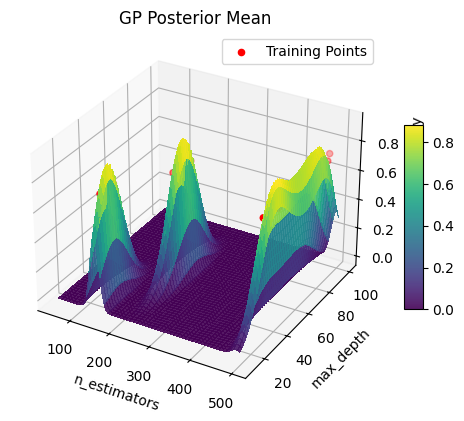

In [122]:
best = bayesian_opt(objective, sigma=10)

Accuracy (default):  0.7733333333333333


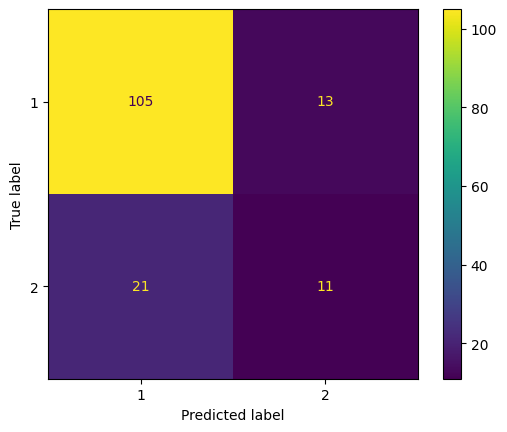

In [123]:
classifier = RandomForestClassifier(n_estimators=int(best[0][0]), max_depth=int(best[0][1]), random_state=11)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (default): ", accuracy)
        
# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = c_matrix.ravel()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)